In [9]:
from agents.theoritical_agent import *
from agents.angle_agent import *
from agents.observation_agent import *
from agents.control_rnn import *
from agents.pre_rnn import *
from agents.post_rnn import *
from agents.universal_rnn import *
from env import *
import numpy as np
from tf_to_mat import *

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [10]:
tf.keras.backend.set_floatx('float64')

In [11]:
#Parameters
kappa = 0.5 #Kappa for the von mises
deck_size = 12 #length sequences
optimal_training = False #Training on optimal labels instead of real ones

nb = 1 #Nb of networks to train
batch_size = 2000 #Batch size for the training (length of the training)
rnn_noise = None #Std for noisy networks (put None if you don't want a noisy network)
random_training = True #Training on sequence of random length chosen uniformely in [|1,12|]
separated_params = (10,2) #(Nb of neurons which will see the first part of the input,size of the first part of the input)

free_feedback = True #True = free feedback in the recurrent network / False = only REF -> SEQ feedbacks

activation = 'tanh' #Activation function

separated = False #Separated network

condition = 'pre'

In [12]:
if optimal_training:
    random_training = False #Random training cannot be used with random_training (technical issues)

### Training

In [13]:
env = Env(deck_size,kappa=kappa,condition=condition)
agent = PreRNN(64,activation=activation,noise=rnn_noise)
agent.postname = condition #Set path name for saving and loading

In [14]:
agent.train(env,3000,batch_size=batch_size,nb_fit=5,verbose=1)
agent.save('PreRNN-'+str(condition)+'-'+str(rnn_noise))

0 0.489
1 0.50125
2 0.5045000000000001
3 0.50425
4 0.5167999999999999
5 0.5269166666666666
6 0.5346428571428571
7 0.5439375
8 0.5476666666666666
9 0.5525
10 0.5654
11 0.5761499999999999
12 0.5863
13 0.59615
14 0.5993
15 0.6039
16 0.6072
17 0.6071
18 0.6073
19 0.61025
20 0.61205
21 0.61205
22 0.6129499999999999
23 0.6163500000000001
24 0.6192500000000001
25 0.6194999999999999
26 0.62055
27 0.6219500000000001
28 0.6263500000000001
29 0.6256
30 0.6254500000000001
31 0.6249
32 0.6269
33 0.62645
34 0.62835
35 0.6292
36 0.6320500000000001
37 0.6364000000000001
38 0.6402
39 0.6463
40 0.6481
41 0.6543999999999999
42 0.65635
43 0.6595500000000001
44 0.6635500000000001
45 0.66565
46 0.6671000000000001
47 0.6666
48 0.66785
49 0.66645
50 0.6695499999999999
51 0.6691999999999999
52 0.6707
53 0.6721999999999999
54 0.6704999999999999
55 0.67145
56 0.6714499999999999
57 0.67395
58 0.6748000000000001
59 0.6742
60 0.67165
61 0.6719
62 0.6724
63 0.67235
64 0.67115
65 0.6756
66 0.67805
67 0.67735
68 0.677

In [ ]:
agent.save('PreRNN-'+str(condition)+'-'+str(rnn_noise))

SAVING ['nn', 'context_nn', 'out_nn']


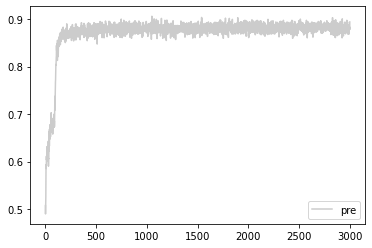

In [ ]:
#Plot accuracies
plt.plot(range(len(agent.scores)),agent.scores,alpha=0.4,color='grey',label=condition)
plt.legend()
plt.show()

### Plots

In [ ]:
env = Env(deck_size,kappa=kappa,condition=condition)
agent = UniversalRNN(64,activation=activation,noise=rnn_noise)
agent.postname = condition #Set path name for saving and loading

In [ ]:
agent.load('PreRNN-'+str(condition)+'-'+str(rnn_noise))

LOADING ['nn', 'out_nn']


ValueError: Received incompatible tensor with shape (2, 64) when attempting to restore variable with shape (4, 64) and name rnn/simple_rnn_cell/kernel:0.

In [ ]:
agent.evaluate(env.sample_batch(1000))

0.783

In [ ]:
from sklearn.decomposition import PCA
from analyse.plot_pca import *

In [ ]:
pca_batch_size = 2000 #Batch size to fit the PCA on
pca_axes = [0,1,2] #Axes of the pca to plot (3 max)

nb_variance = 10 #Nb of variance to plot

In [ ]:
#Pre compute batch
batch_obsf = env.sample_batch(pca_batch_size) 
batch_obs = batch_obsf.get('obs')

In [ ]:
#Def residue function
def residue(X,Y):
    from sklearn.linear_model import LinearRegression
    Lg = LinearRegression()
    XX = np.reshape(X,(-1,X.shape[-1]))
    YY = Y
    Lg.fit(YY,XX)
    print("score",Lg.score(YY,XX))
    #assert False
    pred = Lg.predict(YY)
    pred = np.reshape(pred,X.shape)
    return X - pred

In [ ]:
out = agent.nn(batch_obs).numpy()[:,:,:]
choice = agent.predict(batch_obsf).numpy()

In [ ]:
batch_obsf.get('ref')

array([0.        , 3.92699082, 1.57079633, ..., 0.78539816, 0.        ,
       5.49778714])

In [ ]:
#Residue ref
#cosref = np.cos(batch_obsf.get('ref'))[:,None]
#sinref = np.sin(batch_obsf.get('ref'))[:,None]
#ref = np.concatenate([cosref,sinref],axis=1)
#ref = ref[:,None,:].repeat(out.shape[1],axis=1).reshape((-1,2))
#out = residue(out,ref)

#Residue choice
#choice_batch = choice[:,None].repeat(out.shape[1],axis=1).reshape((-1,1))
#out = residue(out, choice_batch)

#Residue mean angle
#mean_angle = np.mean(batch_obsf.get('obs')[:,:,:2],axis=1)[:,None,:].repeat(out.shape[1],axis=1).reshape((-1,2))
#out = residue(out,mean_angle)

score 0.07116352729614214


In [ ]:
#fit pca
pca = fit_pca(out.reshape((-1,64)),nb_components=nb_variance)
pca_batch = pca.transform(out.reshape((-1,64))).reshape(out.shape[:-1]+(nb_variance,))

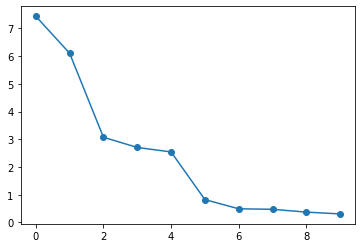

In [ ]:
%matplotlib inline
#plot explained variance
plt.plot(range(nb_variance),pca.explained_variance_,marker='o')
plt.show()

In [ ]:
batch_obsf.get('mean')

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [7.06858347, 7.06858347, 7.06858347, ..., 7.06858347, 7.06858347,
        7.06858347],
       [4.71238898, 4.71238898, 4.71238898, ..., 4.71238898, 4.71238898,
        4.71238898],
       ...,
       [3.92699082, 3.92699082, 3.92699082, ..., 3.92699082, 3.92699082,
        3.92699082],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [8.6393798 , 8.6393798 , 8.6393798 , ..., 8.6393798 , 8.6393798 ,
        8.6393798 ]])

In [ ]:
plt.get_cmap('rainbow')(0),plt.get_cmap('rainbow')(1)

((0.5, 0.0, 1.0, 1.0),
 (0.49215686274509807, 0.012319659535238442, 0.9999810273487268, 1.0))

In [ ]:
#Plot background function
def plot_bg(pca_batch,zorder=0):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('pca1')
    ax.set_ylabel('pca2')
    ax.set_zlabel('pca3')
    colors = [(i/deck_size,(1-i/deck_size),(i-6)**2/36) for i in range(pca_batch.shape[1])]
    cm = plt.get_cmap('rainbow')
    obj = batch_obsf.get('mean')[:,0]/(2*np.pi)
    obj = batch_obsf.get('ref')/(2*np.pi)
    mean_angle = np.mean(batch_obsf.get('obs')[:,:,:2],axis=1)
    obj = (np.arctan2(mean_angle[:,1],mean_angle[:,0])+np.pi)/(2*np.pi)
    #obj = batch_obsf.get('color')/0.5
    obj = choice/0.5
    colors = [[cm(ref) for ref in obj] for i in range(pca_batch.shape[1])]
    unique_refs = np.unique(obj)
    for i,r in enumerate(unique_refs):
        c = cm(r)
        label = str(r)
        ax.plot([0],[0],[0],color=c,label=label,zorder=zorder)
    for i in range(pca_batch.shape[1]):
        ax.scatter(pca_batch[:,i,2],pca_batch[:,i,3],pca_batch[:,i,4],color=colors[i],alpha=0.1,marker='.',zorder=zorder)

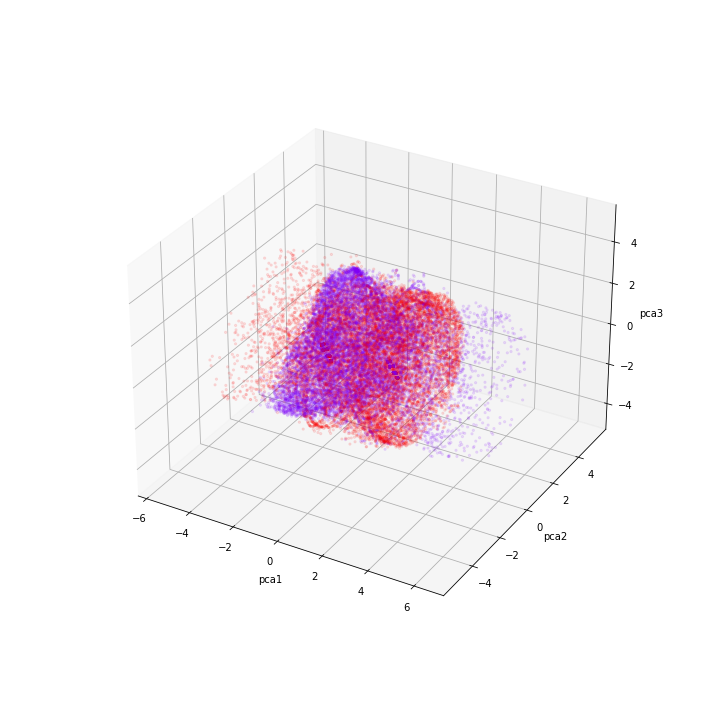

In [ ]:
%matplotlib widget
from mpl_toolkits import mplot3d
plot_bg(pca_batch)
plt.show()